In [344]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import seaborn as sns
import itertools
import matplotlib.pyplot as plt

In [346]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [347]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), 
                                                    df['cardio'], random_state=0)

In [348]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [349]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [350]:
classifier = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=42)),
])


# запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7864573689384385+-0.004422021036885763


In [373]:
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.38693708911473634, F-Score=0.730, Precision=0.647, Recall=0.838


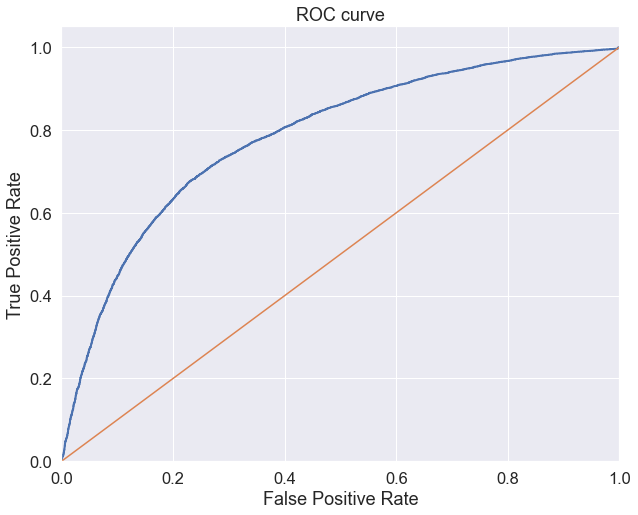

In [374]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [375]:
from sklearn.metrics import roc_auc_score

print(f"roc auc score: {roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1])}")

print(f"roc auc score: {roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])}")
roc = roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])

roc auc score: 0.7870081561637485
roc auc score: 0.7840347790421852


In [376]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


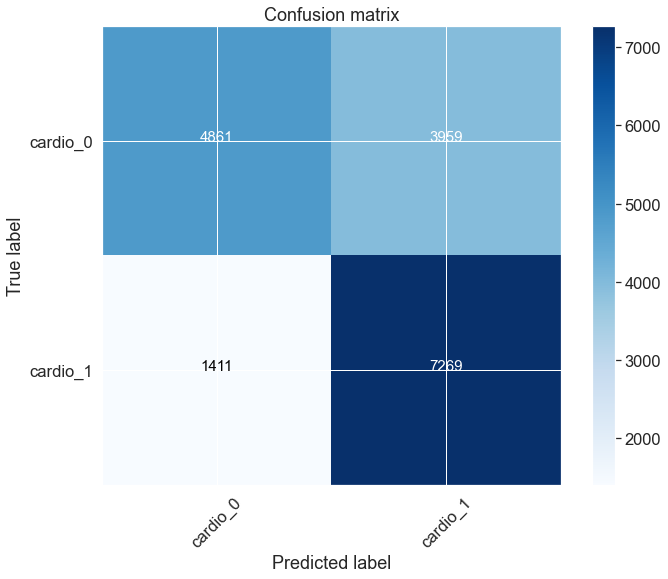

In [377]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [378]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

In [379]:
rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

In [380]:
rubl_1 = (FN + TP) * rubl_late_treatment
print('расходы, если не делать тест и ждать симптомов:', rubl_1)

расходы, если не делать тест и ждать симптомов: 173600000


In [381]:
rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
print('расходы, если делать тест всем и лечить группу больных:', rubl_test_all)

расходы, если делать тест всем и лечить группу больных: 154700000


In [382]:
rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

расходы, если использовать МЛ: 152974200


In [383]:
print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML)
print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML)

Расходы "решение не делать тесты - расходы с МL:" 20625800
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1725800


In [430]:
money = pd.DataFrame(columns = ['model', 'Нет теста-симптомы', 'Тесты всем', 'с ML'] )
expenses = pd.DataFrame(columns = ['model', 'не делать тесты - расходы с МL', 'не делать тесты - тесты всем',
                                   'тесты всем - решение делать тесты ML'] )

In [431]:
money = money.append({
    'model' : 'LogisticRegression',
    'Нет теста-симптомы' : rubl_1,
    'Тесты всем' : rubl_test_all,
    'с ML' : rubl_ML
}, ignore_index=True)
money

,model,Нет теста-симптомы,Тесты всем,с ML
0,LogisticRegression,173600000,154700000,152974200


In [432]:
expenses = expenses.append({
    'model' : 'LogisticRegression',
    'не делать тесты - расходы с МL' : rubl_1 - rubl_ML,
    'не делать тесты - тесты всем' : rubl_1 - rubl_test_all, 
    'тесты всем - решение делать тесты ML' : rubl_test_all - rubl_ML
}, ignore_index=True)
expenses

,model,не делать тесты - расходы с МL,не делать тесты - тесты всем,тесты всем - решение делать тесты ML
0,LogisticRegression,20625800,18900000,1725800


In [384]:
def business_threshold_calibrate(y_test, y_score, thresholds,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1_000_000_000 

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
        
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_buisness_tr
            
            rubl_ML_ = rubl_ML
            
        rs.append(rubl_ML)   
            
    print('расходы, если использовать МЛ:', rubl_ML_)

    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

расходы, если использовать МЛ: 152712400


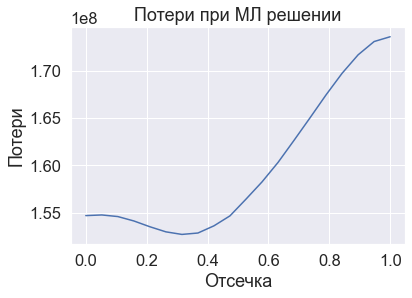

уровень порога по бизнес метрике 0.3157894736842105
уровень порога по f1 метрике 0.38693708911473634


In [385]:
busines_tr = business_threshold_calibrate(y_test, y_score, 
                                          thresholds[ix],
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', thresholds[ix])

In [404]:
result = pd.DataFrame(columns = ['model', 'F-Score', 'Precision', 'Recall', 'roc_auc_score'] )
result

,model,F-Score,Precision,Recall,roc_auc_score


In [405]:
result = result.append({
    'model' : 'LogisticRegression',
    'F-Score' : fscore[ix],
    'Precision' : precision[ix],
    'Recall' : recall[ix],
    'roc_auc_score' : roc,
}, ignore_index=True)
result

,model,F-Score,Precision,Recall,roc_auc_score
0,LogisticRegression,0.738909,0.678788,0.810714,0.800497


Лес решений

In [406]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [407]:
clf = RandomForestClassifier(n_estimators=500, max_depth=9, max_features=4)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_features=4, n_estimators=500)

In [408]:
y_score = clf.predict_proba(X_test)[:, 1]

In [409]:
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.4012756006283691, F-Score=0.740, Precision=0.700, Recall=0.785


In [410]:
roc = roc_auc_score(y_test, y_score)

In [411]:
result = result.append({
    'model' : 'RandomForest',
    'F-Score' : fscore[ix],
    'Precision' : precision[ix],
    'Recall' : recall[ix],
    'roc_auc_score' : roc,
}, ignore_index=True)
result

,model,F-Score,Precision,Recall,roc_auc_score
0,LogisticRegression,0.738909,0.678788,0.810714,0.800497
1,RandomForest,0.740033,0.700103,0.784793,0.801946


Confusion matrix, without normalization
[[5902 2918]
 [1869 6811]]


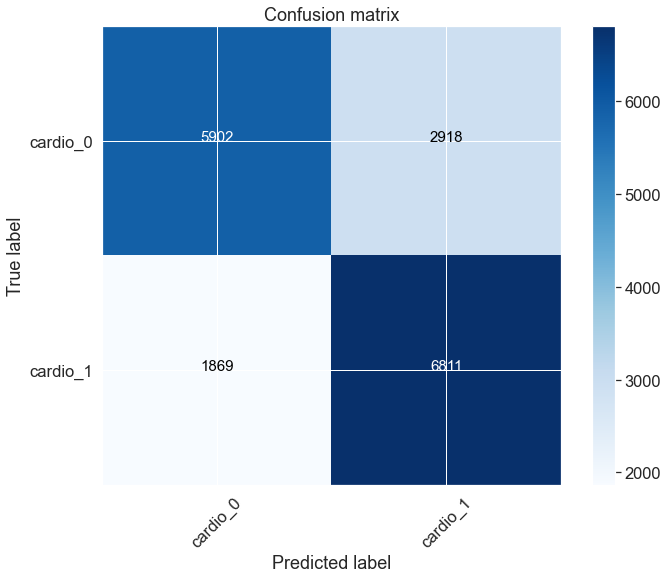

In [412]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [413]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.7846774193548387, 0.3308390022675737, 0.6691609977324263)

In [414]:
rubl_1 = (FN + TP) * rubl_late_treatment
print('расходы, если не делать тест и ждать симптомов:', rubl_1)

расходы, если не делать тест и ждать симптомов: 173600000


In [433]:
rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
print('расходы, если делать тест всем и лечить группу больных:', rubl_test_all)

расходы, если делать тест всем и лечить группу больных: 154700000


In [434]:
rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

расходы, если использовать МЛ: 153165600


In [435]:
print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML)
print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML)

Расходы "решение не делать тесты - расходы с МL:" 20434400
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1534400


In [437]:
money = money.append({
    'model' : 'RandomForest',
    'Нет теста-симптомы' : rubl_1,
    'Тесты всем' : rubl_test_all,
    'с ML' : rubl_ML
}, ignore_index=True)
money

,model,Нет теста-симптомы,Тесты всем,с ML
0,LogisticRegression,173600000,154700000,152974200
1,LogisticRegression,173600000,154700000,153165600
2,RandomForest,173600000,154700000,153165600


In [438]:
expenses = expenses.append({
    'model' : 'RandomForest',
    'не делать тесты - расходы с МL' : rubl_1 - rubl_ML,
    'не делать тесты - тесты всем' : rubl_1 - rubl_test_all, 
    'тесты всем - решение делать тесты ML' : rubl_test_all - rubl_ML
}, ignore_index=True)
expenses

,model,не делать тесты - расходы с МL,не делать тесты - тесты всем,тесты всем - решение делать тесты ML
0,LogisticRegression,20625800,18900000,1725800
1,RandomForest,20434400,18900000,1534400


CatBoost

In [439]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()

In [440]:
cat.fit(X_train,y_train,verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [441]:
y_score = cat.predict(X_test)

In [442]:
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.37173854020152736, F-Score=0.739, Precision=0.679, Recall=0.811


In [443]:
roc = roc_auc_score(y_test, y_score)

In [444]:
result = result.append({
    'model' : 'CatBoost',
    'F-Score' : fscore[ix],
    'Precision' : precision[ix],
    'Recall' : recall[ix],
    'roc_auc_score' : roc,
}, ignore_index=True)
result

,model,F-Score,Precision,Recall,roc_auc_score
0,LogisticRegression,0.738909,0.678788,0.810714,0.800497
1,RandomForest,0.740033,0.700103,0.784793,0.801946
2,CatBoost,0.738909,0.678788,0.810714,0.800497


Confusion matrix, without normalization
[[5490 3330]
 [1644 7036]]


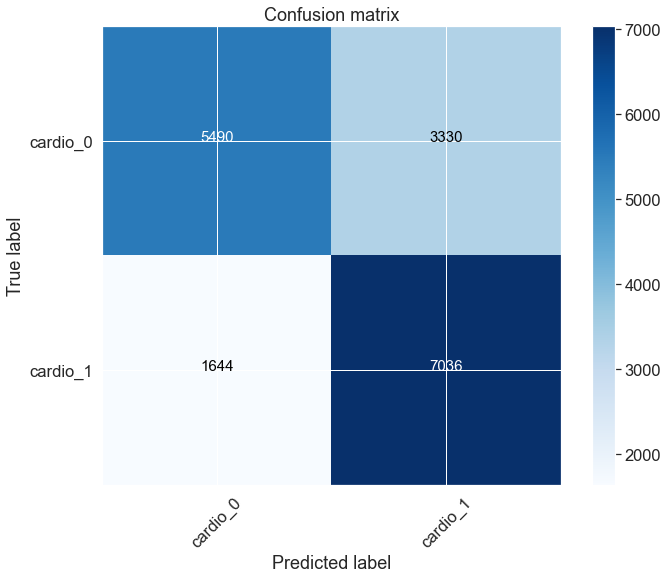

In [445]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [446]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.8105990783410139, 0.37755102040816324, 0.6224489795918368)

In [450]:
rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

расходы, если использовать МЛ: 152932400


In [451]:
print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML)
print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML)

Расходы "решение не делать тесты - расходы с МL:" 20667600
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1767600


In [453]:
money = money.append({
    'model' : 'CatBoost',
    'Нет теста-симптомы' : rubl_1,
    'Тесты всем' : rubl_test_all,
    'с ML' : rubl_ML
}, ignore_index=True)
money

,model,Нет теста-симптомы,Тесты всем,с ML
0,LogisticRegression,173600000,154700000,152974200
1,LogisticRegression,173600000,154700000,153165600
2,RandomForest,173600000,154700000,153165600
3,RandomForest,173600000,154700000,152932400
4,CatBoost,173600000,154700000,152932400


In [454]:
expenses = expenses.append({
    'model' : 'CatBoost',
    'не делать тесты - расходы с МL' : rubl_1 - rubl_ML,
    'не делать тесты - тесты всем' : rubl_1 - rubl_test_all, 
    'тесты всем - решение делать тесты ML' : rubl_test_all - rubl_ML
}, ignore_index=True)
expenses

,model,не делать тесты - расходы с МL,не делать тесты - тесты всем,тесты всем - решение делать тесты ML
0,LogisticRegression,20625800,18900000,1725800
1,RandomForest,20434400,18900000,1534400
2,CatBoost,20667600,18900000,1767600


Судя по табличке money лучше всего отработала модель CatBoost. Если провести ее настройки более точно, то показатели могут улучшиться.

расходы, если использовать МЛ: 152325200


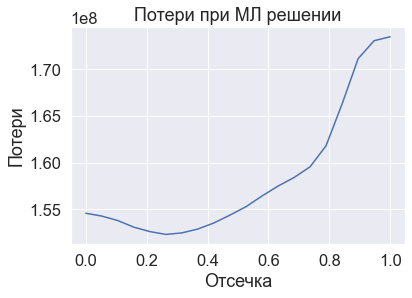

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.37173854020152736


In [455]:
busines_tr = business_threshold_calibrate(y_test, y_score, 
                                          thresholds[ix],
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', thresholds[ix])